In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.metrics import auc, roc_curve

In [2]:
train_X = []
train_y = []

test_X = []
test_y = []

In [3]:
train = os.listdir('train')

In [ ]:
for i in range(len(train)):
    if os.path.isdir("train/" + train[i]):
        for j in range(len(os.listdir('train/' + train[i]))):
            img = cv2.imread('train/' + train[i] + '/' + os.listdir('train/' + train[i])[j])
            train_X.append(img)
            train_y.append(train[i])
        print(train[i] + ' loaded')

In [ ]:
train = list(zip(train_X, train_y)) # shuffle train data

random.shuffle(train)

train_X, train_y = zip(*train)

del train

In [4]:
val = os.listdir('val')

In [5]:
for i in range(len(val)):
    if os.path.isdir("val/" + val[i]):
        for j in range(len(os.listdir('val/' + val[i]))):
            img = cv2.imread('val/' + val[i] + '/' + os.listdir('val/' + val[i])[j])
            test_X.append(img)
            test_y.append(val[i])
        print(val[i] + ' loaded')

no_img loaded
sphere_img loaded
vort_img loaded


In [6]:
val = list(zip(test_X, test_y)) # shuffle test data

random.shuffle(val) 

test_X, test_y = zip(*val)

del val

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_X[i])
    plt.xlabel(train_y[i])
plt.show()

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_X[i])
    plt.xlabel(test_y[i])
plt.show()

In [7]:
le = LabelEncoder()

# train_y = le.fit_transform(train_y)
test_y = le.fit_transform(test_y)

In [8]:
# train_X = np.array(train_X)
# train_y = np.array(train_y)

test_X = np.array(test_X)
test_y = np.array(test_y)

In [9]:
test_X.shape, test_y.shape

((7500, 150, 150, 3), (7500,))

In [ ]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strategy = tf.distribute.TPUStrategy(tpu)

with tpu_strategy.scope():
    model = tf.keras.applications.Xception(
              include_top=True, 
              weights=None,
              input_shape=(150, 150, 3),
              classes=3,
              classifier_activation='softmax'
            )
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_X, train_y, epochs=200, validation_data=(test_X, test_y))

In [13]:
model = tf.keras.models.load_model('test1_auc97.h5', compile=False)

In [14]:
prediction = model.predict(test_X)
prediction = [np.argmax(i) for i in prediction]

temp_pred = [[0, 0, 0] for i in range(len(prediction))]
for i in range(len(prediction)):
    temp_pred[i][prediction[i]] = 1
temp_pred = np.array(temp_pred)


temp_test_y = [[0, 0, 0] for i in range(len(test_y))]

for i in range(len(test_y)):
    temp_test_y[i][test_y[i]] = 1

temp_test_y = np.array(temp_test_y)

235/235 [==============================] - 53s 146ms/step


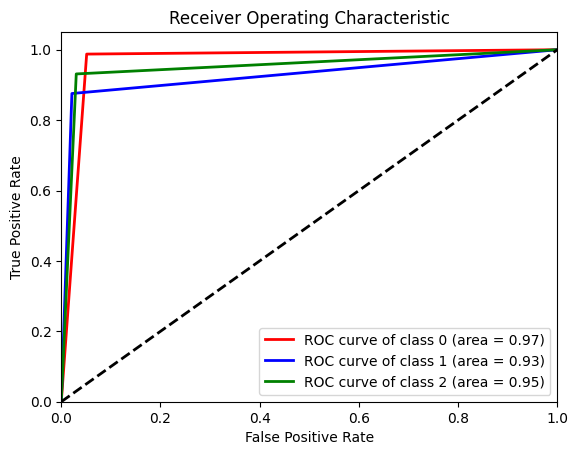

In [15]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(temp_test_y[:, i], temp_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['red', 'blue', 'green']

for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
             
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
model.save('test1_auc97.h5')